# Задание

Есть коллекция 20 NewsGroup. Это коллекция текстов, разбитая по тематическим классам - подходит для задачи классификации. 
https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html


Нужно взять любые три класса из коллекции (или больше, можно и весь датасет, но можно ограничется 3мя). Каждый класс разделить не обучающую и тестовую части. Обучить классификатор Decision Trees. Обучить классификатор на обучающей части и оценить его качество на тестовой. Для оценки качества использовать F1score (разобраться какие варианты использования есть для случая нескольких классов)
https://scikit-learn.org/stable/modules/tree.html

Для работы с текстами, тексты представляются в векторной форме. Всего рассматриваем 9 случаев.
предобработка текста - с лемматизацией и без, и стемминг - на каждый из этих вариантов по 3 варианта векторного представления
- 0,1 
- 0, частота в документе (пояснения были на паре)
- tf-idf

Результаты собрать в таблички для презентации.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups
train_data = fetch_20newsgroups(subset='train')
val_data = fetch_20newsgroups(subset='test')

In [3]:
train_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
print(train_data['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [5]:
len(train_data['data']), len(val_data['data'])

(11314, 7532)

In [6]:
train_data['data'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

## Text preprocessing

In [7]:
DICT_WORDS_COUNT = 1000

In [8]:
! pip install -qq spacy

In [9]:
from tqdm import tqdm
import re
from collections import Counter

In [10]:
from spacy.lang.en import stop_words
stopwords = stop_words.STOP_WORDS

In [11]:
def clean_text(text):

    if 'Lines:' in text:
        start = text.index('Lines:') + 5
        text = text[start:]

    text = text.lower()

    text = re.sub(r'[\w\d.]+@[\w\d]+.[\w\d]+', ' ', text)
    text = re.sub(r'(http|https)://[\w\d/.]+', ' ', text)

    text = re.sub(r'[^\w]+', ' ', text)
    text = re.sub(r'[\d]+', ' ', text)

    text = text.strip()
    
    words = [w for w in text.split() if len(w) > 3 and w not in stopwords]

    return ' '.join(words)

In [12]:
clean_train_texts = [clean_text(text) for text in tqdm(train_data['data'], desc='Train texts')]
clean_val_texts = [clean_text(text) for text in tqdm(val_data['data'], desc='Val texts')]

Val texts: 100%|██████████| 7532/7532 [00:00<00:00, 8281.00it/s]


In [13]:
clean_train_texts[0]

'wondering enlighten door sports looked late early called bricklin doors small addition bumper separate rest body know tellme model engine specs years production history info funky looking mail thanks brought neighborhood lerxst'

### 1. Simple dictionary

In [14]:
simple_counter = Counter()

for text in tqdm(clean_train_texts):
    simple_counter.update(text.split())

simple_dictionary, _ = zip(*simple_counter.most_common(DICT_WORDS_COUNT))
simple_dictionary[:10]

  0%|          | 0/11314 [00:00<?, ?it/s]

100%|██████████| 11314/11314 [00:00<00:00, 91687.19it/s]


('writes',
 'article',
 'people',
 'like',
 'know',
 'think',
 'time',
 'good',
 'posting',
 'host')

### 2. Lemmatization

In [15]:
! spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
import en_core_web_sm

nlp = en_core_web_sm.load()

In [17]:
text = clean_train_texts[0][150:300]
print(text)

doc = nlp(text)
print(' '.join([token.lemma_ for token in doc]))

production history info funky looking mail thanks brought neighborhood lerxst
production history info funky look mail thank bring neighborhood lerxst


In [18]:
lemma_counter = Counter()

for text in tqdm(clean_train_texts):
    doc = nlp(text)
    lemma_counter.update([token.lemma_ for token in doc])

lemma_dictionary, _ = zip(*lemma_counter.most_common(DICT_WORDS_COUNT))
lemma_dictionary[:10]

100%|██████████| 11314/11314 [03:48<00:00, 49.54it/s]


('_',
 'write',
 'article',
 'know',
 'people',
 'like',
 'think',
 'post',
 'time',
 'good')

### 3. Stemming

In [19]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

In [20]:
text = clean_train_texts[200][150:350]
print(text)

print(' '.join([stemmer.stem(w) for w in text.split()]))

anuary purchased firearm march guess like years kirk hays life seventh generation read consulted guns summer purchased firearm early march year lack desire firearm understand purchased rifle shotgun d
anuari purchas firearm march guess like year kirk hay life seventh generat read consult gun summer purchas firearm earli march year lack desir firearm understand purchas rifl shotgun d


In [21]:
stem_counter = Counter()

for text in tqdm(clean_train_texts):
    stem_counter.update([stemmer.stem(w) for w in text.split()])

stem_dictionary, _ = zip(*stem_counter.most_common(DICT_WORDS_COUNT))
stem_dictionary[:10]

  0%|          | 0/11314 [00:00<?, ?it/s]

100%|██████████| 11314/11314 [00:06<00:00, 1749.05it/s]


('write',
 'articl',
 'like',
 'peopl',
 'know',
 'post',
 'think',
 'time',
 'work',
 'year')

## Text vectorizing

In [38]:
def get_binary_bow(text, dictionary='simple'):
    if dictionary == 'lemma':
        lemmas = [token.lemma_ for token in nlp(text)]
        return [(1 if w in lemmas else 0) for w in lemma_dictionary]
    elif dictionary == 'stem':
        stems = [stemmer.stem(w) for w in text.split()]
        return [(1 if w in stems else 0) for w in stem_dictionary]
    else:
        words = text.split()
        return [(1 if w in words else 0) for w in simple_dictionary]

In [39]:
def get_bow(text, dictionary='simple'):
    dcts = {
        'simple': simple_dictionary,
        'lemma': lemma_dictionary,
        'stem': stem_dictionary,
    }
    if dictionary == 'lemma':
        words = [token.lemma_ for token in nlp(text)]
    elif dictionary == 'stem':
        words = [stemmer.stem(w) for w in text.split()]
    else:
        words = text.split()
    
    cnt = Counter(words)
    vec = [(0 if w not in cnt else cnt[w]) for w in dcts[dictionary]]
    return vec

In [40]:
def get_tfidf(text, dictionary='simple'):
    pass

In [41]:
df = pd.DataFrame(clean_train_texts, columns=['text'])
df['target'] = train_data['target']
df

,text,target
0,wondering enlighten door sports looked late ea...,7
1,nntp posting host carson washington fair numbe...,4
2,folks plus finally gave ghost weekend starting...,4
3,distribution world nntp posting host amber har...,1
4,article baker article pack writes clear cautio...,14
...,...,...
11309,david neurology consultation cheaper scan bett...,13
11310,organization tufts university medford plus pro...,4
11311,installed clone motherboard tried mounting coo...,3
11312,nntp posting host hcrlgw article washington wa...,1


In [42]:
def get_df(df, dictionary='simple', vectorizor=get_binary_bow):
    df = df.copy()
    vec = pd.DataFrame(np.vstack(df['text'].apply(lambda s: vectorizor(s, dictionary))))
    vec['target'] = df['target'].tolist()
    return vec

In [43]:
df_train = df.sample(1000)
df_train

,text,target
4782,article romanick writes thing small change ini...,1
6751,article writes mend bridges iran people pissed...,18
905,writes wrong wasn jeff fenholt black sabbath m...,15
9014,tell find mpeg viewer windows thanks advance a...,1
7312,droplet vast ocean miraculous translations ara...,19
...,...,...
1319,stephen legge munc writes wtahcing right guard...,10
2270,article upenn alan sepinwall writes pleasant p...,9
8061,quadra noticed change desktop color beautiful ...,4
10907,shipping year adobe display postscript silicon...,1


In [49]:
# Bag-of-words
get_df(df_train, dictionary='lemma', vectorizor=get_bow)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,target
0,0,1,1,1,0,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
2,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,15
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,3,0,0,2,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,10
996,0,1,1,0,0,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,9
997,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
# Binary Bag-of-words
get_df(df_train, dictionary='lemma', vectorizor=get_binary_bow)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,target
0,0,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
2,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,15
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,10
996,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9
997,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [45]:
dfs = [[None] * 2] * 3

0 bow completed
0 bin bow completed
1 bow completed
1 bin bow completed
2 bow completed
2 bin bow completed


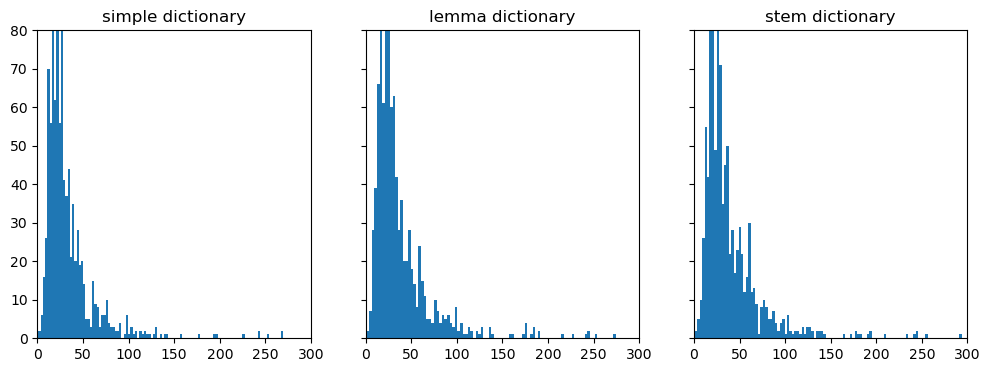

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex='all', sharey='all')

d_names = ['simple', 'lemma', 'stem']

for i, d in enumerate(d_names):
    dfs[i][1] = get_df(df_train, d, get_bow)
    print(i, 'bow completed')
    dfs[i][0] = vecdf = get_df(df_train, d, get_binary_bow)
    print(i, 'bin bow completed')
    axs[i].hist(vecdf.drop('target', axis=1).sum(), bins=200)
    axs[i].set_title(f'{d} dictionary')
    axs[i].set_xlim((0, 300))
    axs[i].set_ylim((0, 80))

## Decision tree training

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [48]:
d_names = ['simple', 'lemma', 'stem']
v_names = ['BinBOW', 'BOW']

print('Dict size:', DICT_WORDS_COUNT)

for md in [8, 16, 64]:
    print('-' * 25 + f' max_depth={md} ' + '-' * 25)
    for j, v in enumerate([get_binary_bow, get_bow]):
        for i in range(len(d_names)):

            X_train, X_val, y_train, y_val = train_test_split(
                dfs[i][j].drop('target', axis=1),
                dfs[i][j]['target'],
                test_size=0.2,
                shuffle=True,
                random_state=42,
            )
                        
            clf = DecisionTreeClassifier(
                max_depth=md,
                random_state=42,
            )
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='macro')

            print(f'{d_names[i]:6} + {v_names[j]:6}  =>  acc={acc:.4f}, macro-f1={f1:.4f}')
        print()

Dict size: 1000
------------------------- max_depth=8 -------------------------
simple + BinBOW  =>  acc=0.2300, macro-f1=0.2249
lemma  + BinBOW  =>  acc=0.2300, macro-f1=0.2249
stem   + BinBOW  =>  acc=0.2300, macro-f1=0.2249

simple + BOW     =>  acc=0.2300, macro-f1=0.2332
lemma  + BOW     =>  acc=0.2300, macro-f1=0.2332
stem   + BOW     =>  acc=0.2300, macro-f1=0.2332

------------------------- max_depth=16 -------------------------
simple + BinBOW  =>  acc=0.3000, macro-f1=0.3091
lemma  + BinBOW  =>  acc=0.3000, macro-f1=0.3091
stem   + BinBOW  =>  acc=0.3000, macro-f1=0.3091

simple + BOW     =>  acc=0.2950, macro-f1=0.3390
lemma  + BOW     =>  acc=0.2950, macro-f1=0.3390
stem   + BOW     =>  acc=0.2950, macro-f1=0.3390

------------------------- max_depth=64 -------------------------
simple + BinBOW  =>  acc=0.3800, macro-f1=0.3530
lemma  + BinBOW  =>  acc=0.3800, macro-f1=0.3530
stem   + BinBOW  =>  acc=0.3800, macro-f1=0.3530

simple + BOW     =>  acc=0.3550, macro-f1=0.3413
l

Micro- и macro- precision, recall, f1, ...

https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii